# **BF550 Final Project Script**
Maha Naim
# **Paper:** 
Yin, X., Hu, L., Zhang, Y. et al. PDGFB-expressing mesenchymal stem cells improve human hematopoietic stem cell engraftment in immunodeficient mice. Bone Marrow Transplant 55, 1029–1040 (2020). https://doi.org/10.1038/s41409-019-0766-z



# **Analysis 1**: Log2FC & FDR Calculation

# **Plot 1**: Volcano Plot


In [ ]:
# Installed bioinfokit
pip install bioinfokit

# Installed RNAlysis to analyze RNA sequencing data
pip install rnalysis

In [50]:
# Importing necessary modules
import pandas as pd
import numpy as np
from rnalysis import filtering
from bioinfokit.analys import norm
from bioinfokit import analys, visuz
from scipy.stats import ttest_ind
import scipy.stats as stats
import matplotlib.pylab as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import statsmodels as sm

In [51]:
# Reading in data file
data = pd.read_csv("/content/GSE113857_TPM_matrix.txt", sep = '\t', header = 0)

# Viewing some of the data - looks good 
data.head()

# Writing to CSV
data.to_csv("/content/data.csv")

# Re-reading in the data, but this time as a CSV 
data_file = pd.read_csv("/content/data.csv", sep = ',', header = 0)

# Setting the index of the dataframe to the unique genes
data_indexed = data_file.set_index('GeneSymbol')

# Viewing the data - has an unnamed column that needs to be dropped
data_indexed.head()

# Removing the numbering column 
data_official = data_indexed.drop(["Unnamed: 0"], axis=1)

# Checking for NA values - none reported
print(data_official.isnull().sum().sum())

# Overview of the new data
data_official.head()

# Normalizing
nm = norm()

0


## Calculating means for each group, which are then used to compute fold change

In [52]:
# Calculating the mean along the GFP-transduced MSCs (GFP-MSC)
data_official["Mean_GFP"] = data_official[['GFP-MSC1', 'GFP-MSC2', 'GFP-MSC3']].mean(axis=1)

# Calculating the mean along the PDGFB-transduced MSCs (PDGFB-MSC)
data_official["Mean_PDGFB"] = data_official[['PDGFB-MSC1', 'PDGFB-MSC2', 'PDGFB-MSC3']].mean(axis=1)

# Computing the fold change using the calculated means
data_official["Fold_Change"] = data_official["Mean_GFP"] / data_official["Mean_PDGFB"]

# Replacing infinite values with NaN 
data_official = data_official.replace([np.inf, -np.inf], np.nan)

# Replace these new NaN values with 0
data_official = data_official.fillna(0)

# Overview of the data with computed statistics - data looks good for further analysis
data_official.head()

,GFP-MSC1,GFP-MSC2,GFP-MSC3,PDGFB-MSC1,PDGFB-MSC2,PDGFB-MSC3,Mean_GFP,Mean_PDGFB,Fold_Change
GeneSymbol,,,,,,,,,
MT-TP,1230.7200,1028.73000,1125.04000,856.71900,896.5030,936.30800,1128.163333,896.510000,1.258395
MT-CYB,2721.0000,2713.74000,2710.48000,2320.34000,2565.7500,2479.03000,2715.073333,2455.040000,1.105918
MT-TE,15.0507,14.85990,2.76691,3.80397,10.7793,8.68845,10.892503,7.757240,1.404173
MT-TS2,0.0000,1.98488,4.97836,0.00000,0.0000,0.00000,2.321080,0.000000,0.000000
MT-ND4,2656.9700,2686.09000,2698.84000,2212.26000,2340.6600,2250.79000,2680.633333,2267.903333,1.181987


## Computing the log2FC and standard deviation of the data

In [53]:
# Computing log2 fold change from fold change values
data_official["log2_FC"] = np.log2(data_official["Fold_Change"])

# Computing standard deviation
data_official["STD_GFP"] = data_official[["GFP-MSC1","GFP-MSC2","GFP-MSC3"]].std(ddof=0,axis=1)
data_official["STD_PDGFB"] = data_official[["PDGFB-MSC1","PDGFB-MSC2","PDGFB-MSC3"]].std(ddof=0,axis=1)

# Overview of data
data_official.head()

,GFP-MSC1,GFP-MSC2,GFP-MSC3,PDGFB-MSC1,PDGFB-MSC2,PDGFB-MSC3,Mean_GFP,Mean_PDGFB,Fold_Change,log2_FC,STD_GFP,STD_PDGFB
GeneSymbol,,,,,,,,,,,,
MT-TP,1230.7200,1028.73000,1125.04000,856.71900,896.5030,936.30800,1128.163333,896.510000,1.258395,0.331584,82.491642,32.492074
MT-CYB,2721.0000,2713.74000,2710.48000,2320.34000,2565.7500,2479.03000,2715.073333,2455.040000,1.105918,0.145245,4.397039,101.614163
MT-TE,15.0507,14.85990,2.76691,3.80397,10.7793,8.68845,10.892503,7.757240,1.404173,0.489720,5.746190,2.922804
MT-TS2,0.0000,1.98488,4.97836,0.00000,0.0000,0.00000,2.321080,0.000000,0.000000,-inf,2.046263,0.000000
MT-ND4,2656.9700,2686.09000,2698.84000,2212.26000,2340.6600,2250.79000,2680.633333,2267.903333,1.181987,0.241215,17.523425,53.797705


## Calculating p-values and then performing FDR correction

In [54]:
# Initializing list to store p-values
p_values = []

# For loop going through total count of gene symbols (39,037) and computing p-values 
for i in range(0,39037):
  GFP = []
  PDGFB = []
  GFP = data_official.iloc[i,0:3]
  GFP = list(GFP)
  PDGFB = data_official.iloc[i,3:6]
  PDGFB = list(PDGFB)
  stat, p = ttest_ind(GFP, PDGFB)
  p_values.append(p)

# Correcting p-values to FDR
fdr = sm.stats.multitest.fdrcorrection(p_values, alpha=0.05, method='indep', is_sorted=False)

# Adding FDR column to dataframe
data_official["FDR"] = fdr[1]

# Adding p_value column to dataframe
data_official["P_value"] = p_values

# Final data frame
data_official

,GFP-MSC1,GFP-MSC2,GFP-MSC3,PDGFB-MSC1,PDGFB-MSC2,PDGFB-MSC3,Mean_GFP,Mean_PDGFB,Fold_Change,log2_FC,STD_GFP,STD_PDGFB,FDR,P_value
GeneSymbol,,,,,,,,,,,,,,
MT-TP,1230.720000,1028.730000,1125.040000,856.719000,896.503000,936.30800,1128.163333,896.510000,1.258395,0.331584,82.491642,32.492074,0.160293,0.020925
MT-CYB,2721.000000,2713.740000,2710.480000,2320.340000,2565.750000,2479.03000,2715.073333,2455.040000,1.105918,0.145245,4.397039,101.614163,0.166941,0.022444
MT-TE,15.050700,14.859900,2.766910,3.803970,10.779300,8.68845,10.892503,7.757240,1.404173,0.489720,5.746190,2.922804,0.716362,0.529404
MT-TS2,0.000000,1.984880,4.978360,0.000000,0.000000,0.00000,2.321080,0.000000,0.000000,-inf,2.046263,0.000000,0.505300,0.183949
MT-ND4,2656.970000,2686.090000,2698.840000,2212.260000,2340.660000,2250.79000,2680.633333,2267.903333,1.181987,0.241215,17.523425,53.797705,0.024583,0.000498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FADS2,247.520000,238.268000,224.244000,289.579000,295.245000,284.13600,236.677333,289.653333,0.817106,-0.291406,9.568724,4.535535,0.047139,0.002106
OIT3,0.000000,0.035200,0.000000,0.034709,0.000000,0.00000,0.011733,0.011570,1.014123,0.020233,0.016593,0.016362,0.996761,0.992563
FADS1,38.273800,42.532500,47.289400,37.023400,42.775400,41.41660,42.698567,40.405133,1.056761,0.079649,3.682476,2.454747,0.696346,0.504274


## Generated 3 different plots:
1. Log2FC against FDR from my computed statistics
2. Log2FC against P-value from my computed statistics
3. Log2FC against FDR from the author's pre-computed statistics

269
440


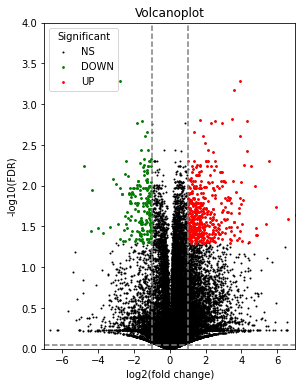

In [55]:
### 1. Plotting against FDR values - this is how the paper does it ###

plt.figure(1, figsize = (4.5,6))
plt.scatter(x = data_official['log2_FC'],y = data_official['FDR'].apply(lambda x:-np.log10(x)),s=1, label = "NS", color="black")

# Subsetting the up and down regulated genes
down = data_official[(data_official['log2_FC']<=-1)&(data_official['FDR']<=0.05)]
up = data_official[(data_official['log2_FC']>=1)&(data_official['FDR']<=0.05)]

# Count of up (269) and down (440) regulated genes - comparable to paper?
print(len(down))
print(len(up))

# Plotting the up and down regulated genes
plt.scatter(x=down['log2_FC'],y=down['FDR'].apply(lambda x:-np.log10(x)),s=3,label="DOWN",color="green")
plt.scatter(x=up['log2_FC'],y=up['FDR'].apply(lambda x:-np.log10(x)),s=3,label="UP",color="red")

# Graphic design
plt.xlabel("log2(fold change)")
plt.ylabel("-log10(FDR)")
plt.title('Volcanoplot')
plt.ylim((0,4))
plt.xlim((-7,7))
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(0.05,color="grey",linestyle="--")
plt.legend(title = "Significant");

714
1598


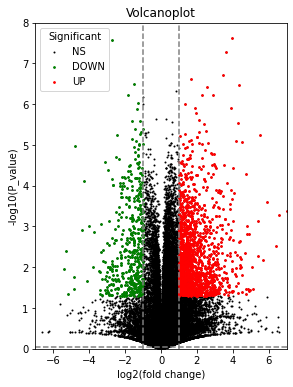

In [56]:
### 2. Plotting against p-values - not needed, but more similar distribution to that reported in the paper ###

plt.figure(1, figsize = (4.5,6))
plt.scatter(x = data_official['log2_FC'],y = data_official['P_value'].apply(lambda x:-np.log10(x)),s = 1, label = "NS", color="black")

# Subsetting the up and down regulated genes
down = data_official[(data_official['log2_FC']<=-1)&(data_official['P_value']<=0.05)]
up = data_official[(data_official['log2_FC']>=1)&(data_official['P_value']<=0.05)]

# Count of up (714) and down (1598) regulated genes - very high compared to paper
print(len(down))
print(len(up))

# Plotting the up and down regulated genes
plt.scatter(x=down['log2_FC'],y=down['P_value'].apply(lambda x:-np.log10(x)),s=3,label="DOWN",color="green")
plt.scatter(x=up['log2_FC'],y=up['P_value'].apply(lambda x:-np.log10(x)),s=3,label="UP",color="red")

# Graphic design
plt.xlabel("log2(fold change)")
plt.ylabel("-log10(P_value)")
plt.title('Volcanoplot')
plt.ylim((0,8))
plt.xlim((-7,7))
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(0.05,color="grey",linestyle="--")
plt.legend(title = "Significant");


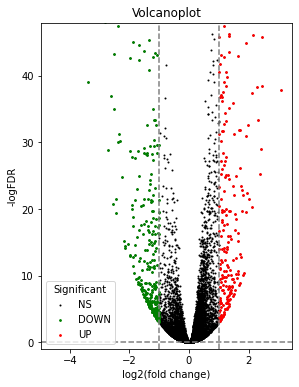

In [57]:
### 3. Plotting against FDR, using the author-provided data file with pre-computed statistics ###

# Reading in the author-provided data file
author = pd.read_csv("/content/DEGs_tablefinalone.txt", sep = '\t', header = 0)
author.to_csv("/content/author.csv")

# Re-reading in the data, but this time as a CSV 
author_file = pd.read_csv("/content/author.csv", sep = ',', header = 0)

# Setting the index of the dataframe to the unique genes
author_indexed = author_file.set_index('GeneID')

# Viewing the data - has an unnamed column that needs to be dropped
author_indexed.head()

# Removing the numbering column 
author_official = author_indexed.drop(["Unnamed: 0"], axis=1)

# Viewing the data
author_official.head()

# Assigning up or downregulated based on paper-reported thresholds
author_official.loc[(author_official['FDR'] <= 0.05) & (author_official['log2(FC)'] >= 1), 'genereg'] = 'upregulated'  
author_official.loc[(author_official['FDR'] <= 0.05) & (author_official['log2(FC)'] <= -1), 'genereg'] = 'downregulated'  

# Confirming that the total amount of upregulated (250) and downregulated (350) genes matches those reported by the paper
((author_official['genereg'])== 'upregulated').sum()
((author_official['genereg'])== 'downregulated').sum()

# Plotting
plt.figure(1, figsize = (4.5,6))
plt.scatter(x=author_official['log2(FC)'],y=author_official['FDR'].apply(lambda x:-np.log10(x)),s=1, label = "NS", color="black")

# Subsetting the up and down regulated genes
down = author_official[(author_official['log2(FC)']<=-1)&(author_official['FDR']<=0.05)]
up = author_official[(author_official['log2(FC)']>=1)&(author_official['FDR']<=0.05)]

# Plotting the up and down regulated genes
plt.scatter(x=down['log2(FC)'],y=down['FDR'].apply(lambda x:-np.log10(x)),s=3,label="DOWN",color="green")
plt.scatter(x=up['log2(FC)'],y=up['FDR'].apply(lambda x:-np.log10(x)),s=3,label="UP",color="red")

# Graphic design
plt.xlabel("log2(fold change)")
plt.ylabel("-logFDR")
plt.title('Volcanoplot')
plt.ylim((-1,48))
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(0.05,color="grey",linestyle="--")
plt.legend(title = "Significant");

# **Analysis 2**: Pearson distances and optimal clusters

# **Plot 2**: Clustered Heatmap

In [58]:
# Reading in data file
data = pd.read_csv("/content/GSE113857_TPM_matrix.txt", sep = '\t', header = 0)

# Gene list
genes = ["DCN","IBSP","EDNRB","GLUL","IER3","AXL","NT5E","RBM24","CRIM1","UGCG","HSPG2","MN1",
          "MAP2K3","IL6","CCL2","CXCL12","IGF2","DLK1","ATF3","PDGFB","PDGFRB","PDGFA","FZD7"]

# Subsetting the data file so that only genes in the list are retained
data_subset = data[data.GeneSymbol.isin(genes)]

# Confirming there are 23 matched genes as rows
data_subset.shape

# Setting the index of the dataframe to the unique genes
data_indexed = data_subset.set_index('GeneSymbol')

# Viewing the data
data_indexed.head()

,GFP-MSC1,GFP-MSC2,GFP-MSC3,PDGFB-MSC1,PDGFB-MSC2,PDGFB-MSC3
GeneSymbol,,,,,,
MN1,10.63600,9.89819,8.05611,11.5423,11.7274,12.82050
MAP2K3,27.75400,30.73200,27.65940,36.0354,41.2258,33.83870
AXL,5.77887,7.51073,5.59621,10.8081,10.9562,9.47801
DLK1,7.38890,10.51550,8.26304,42.9544,39.4228,46.02370
PDGFB,59.81550,37.56690,37.30710,24699.3000,24687.1000,26038.70000


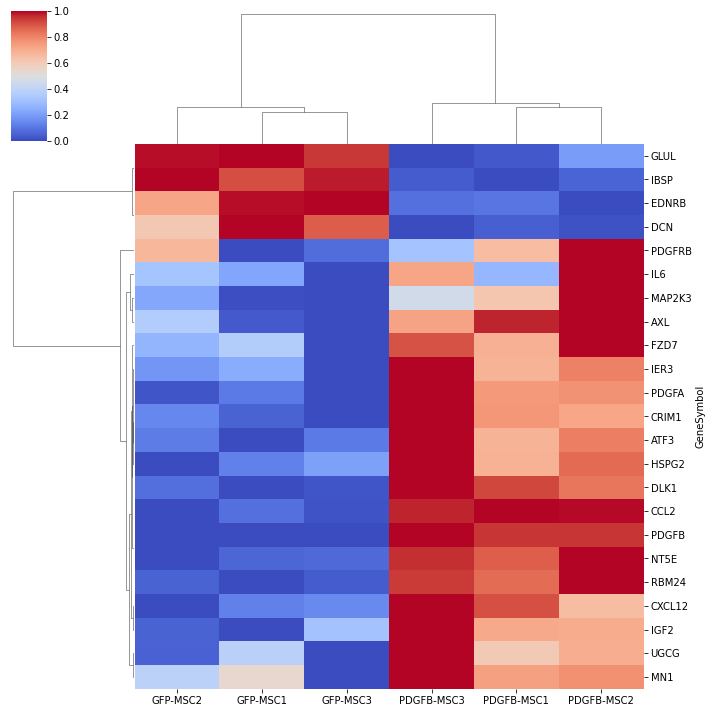

In [59]:
# Computing standard correlations according to the Pearson method
correlations = 1-data_indexed.T.corr(method = 'pearson')

# Computing optimal clusters according to the Ward method 
clusters = sch.linkage(correlations, method = 'ward', optimal_ordering = True)

# Cluster mapping the indexed data according to the computed clusters
sns.clustermap(data_indexed, row_cluster = True, row_linkage = clusters, standard_scale = 0, cmap = 'coolwarm');